In [18]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available
✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [19]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_good_acb.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path}")
else:
    print(f"✗ Model not found: {model_path}")

# # 1.2. Load dữ liệu 
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu từ vnstock...")
# df_raw = provider.get_ohlcv_data('SSI', '2021-12-14', '2024-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2022')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

df_processed_train = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\train\\good_train_GAS.csv')
df_processed_train.rename(columns={'date': 'time'}, inplace=True)
df_processed_train['time'] = pd.to_datetime(df_processed_train['time']).dt.strftime('%d/%m/%Y')

df_processed_test = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_GAS.csv')
df_processed_test.rename(columns={'date': 'time'}, inplace=True)
df_processed_test['time'] = pd.to_datetime(df_processed_test['time']).dt.strftime('%d/%m/%Y')

# Ghép dữ liệu: train trước rồi đến test (theo thời gian) thay vì dùng toán tử '+'
df_processed = pd.concat([df_processed_train, df_processed_test], ignore_index=True)
# Đảm bảo thứ tự thời gian tăng dần nếu chưa chắc chắn
_df_time = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
df_processed = df_processed.assign(_time=_df_time).sort_values('_time').drop(columns=['_time']).reset_index(drop=True)
print(f"✓ Merged train+test: {df_processed.shape} (train={df_processed_train.shape}, test={df_processed_test.shape})")
print(f"  Time range: {df_processed['time'].iloc[0]} -> {df_processed['time'].iloc[-1]}")

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_good_acb.pth


✓ Merged train+test: (2248, 10) (train=(1496, 10), test=(752, 10))
  Time range: 02/01/2013 -> 31/12/2021

Đang chạy simulation...
✓ Simulation hoàn tất: 2248 states, 2247 actions
  Total reward: 12653.75
  Final portfolio: $13653.75


In [20]:
states

[[1.12,
  1000,
  0,
  0.0339672268309489,
  65.65168252720677,
  133.83838383838392,
  30.66057743097034],
 [1.13,
  996.6366399999999,
  3.0,
  0.034779733426947,
  67.17189614821932,
  122.89735667696498,
  31.450804410742187],
 [1.17,
  993.24325,
  6.0,
  0.0382108456212253,
  72.42848953958003,
  173.7221699592344,
  33.30640048170927],
 [1.23,
  989.72974,
  9.0,
  0.0452499124900049,
  78.09460704487807,
  196.34129311548617,
  35.52242056184218],
 [1.28,
  986.0360499999999,
  12.0,
  0.0542377863901597,
  81.50551962636014,
  257.12623618382776,
  38.10891087034761],
 [1.27,
  989.8798899999999,
  9.0,
  0.0598637527063476,
  78.86070713867764,
  194.01896425966456,
  39.277649319731054],
 [1.28,
  986.0660799999999,
  12.0,
  0.0643870738634024,
  79.5744889564572,
  163.2653061224489,
  39.97864563955891],
 [1.27,
  982.2222399999999,
  15.0,
  0.0663995098256149,
  76.78244875375955,
  143.5278336686785,
  40.76102131629749],
 [1.24,
  978.40843,
  18.0,
  0.06482635270397

In [21]:
actions

[3,
 3,
 3,
 3,
 -3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 -4,
 -4,
 4,
 4,
 4,
 4,
 -3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 -1,
 4,
 -1,
 -1,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 -1,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 4,
 4,
 4,
 -1,
 4,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [22]:
df_processed

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,02/01/2013,1.12,1.13,1.11,1.12,541540,0.033967,65.651683,133.838384,30.660577
1,03/01/2013,1.12,1.13,1.11,1.13,720080,0.034780,67.171896,122.897357,31.450804
2,04/01/2013,1.14,1.19,1.13,1.17,569620,0.038211,72.428490,173.722170,33.306400
3,07/01/2013,1.13,1.23,1.13,1.23,926020,0.045250,78.094607,196.341293,35.522421
4,08/01/2013,1.28,1.29,1.26,1.28,1480180,0.054238,81.505520,257.126236,38.108911
...,...,...,...,...,...,...,...,...,...,...
2243,27/12/2021,26.69,26.72,26.11,26.32,10675000,-0.790765,38.046591,-81.527814,35.582105
2244,28/12/2021,26.32,26.77,26.14,26.26,12356700,-0.760894,37.575948,-75.274475,34.748545
2245,29/12/2021,26.26,26.54,26.09,26.26,15118200,-0.728820,37.575948,-81.083806,34.034222
2246,30/12/2021,26.54,26.54,26.20,26.20,10285000,-0.700171,37.044490,-71.993943,33.370921


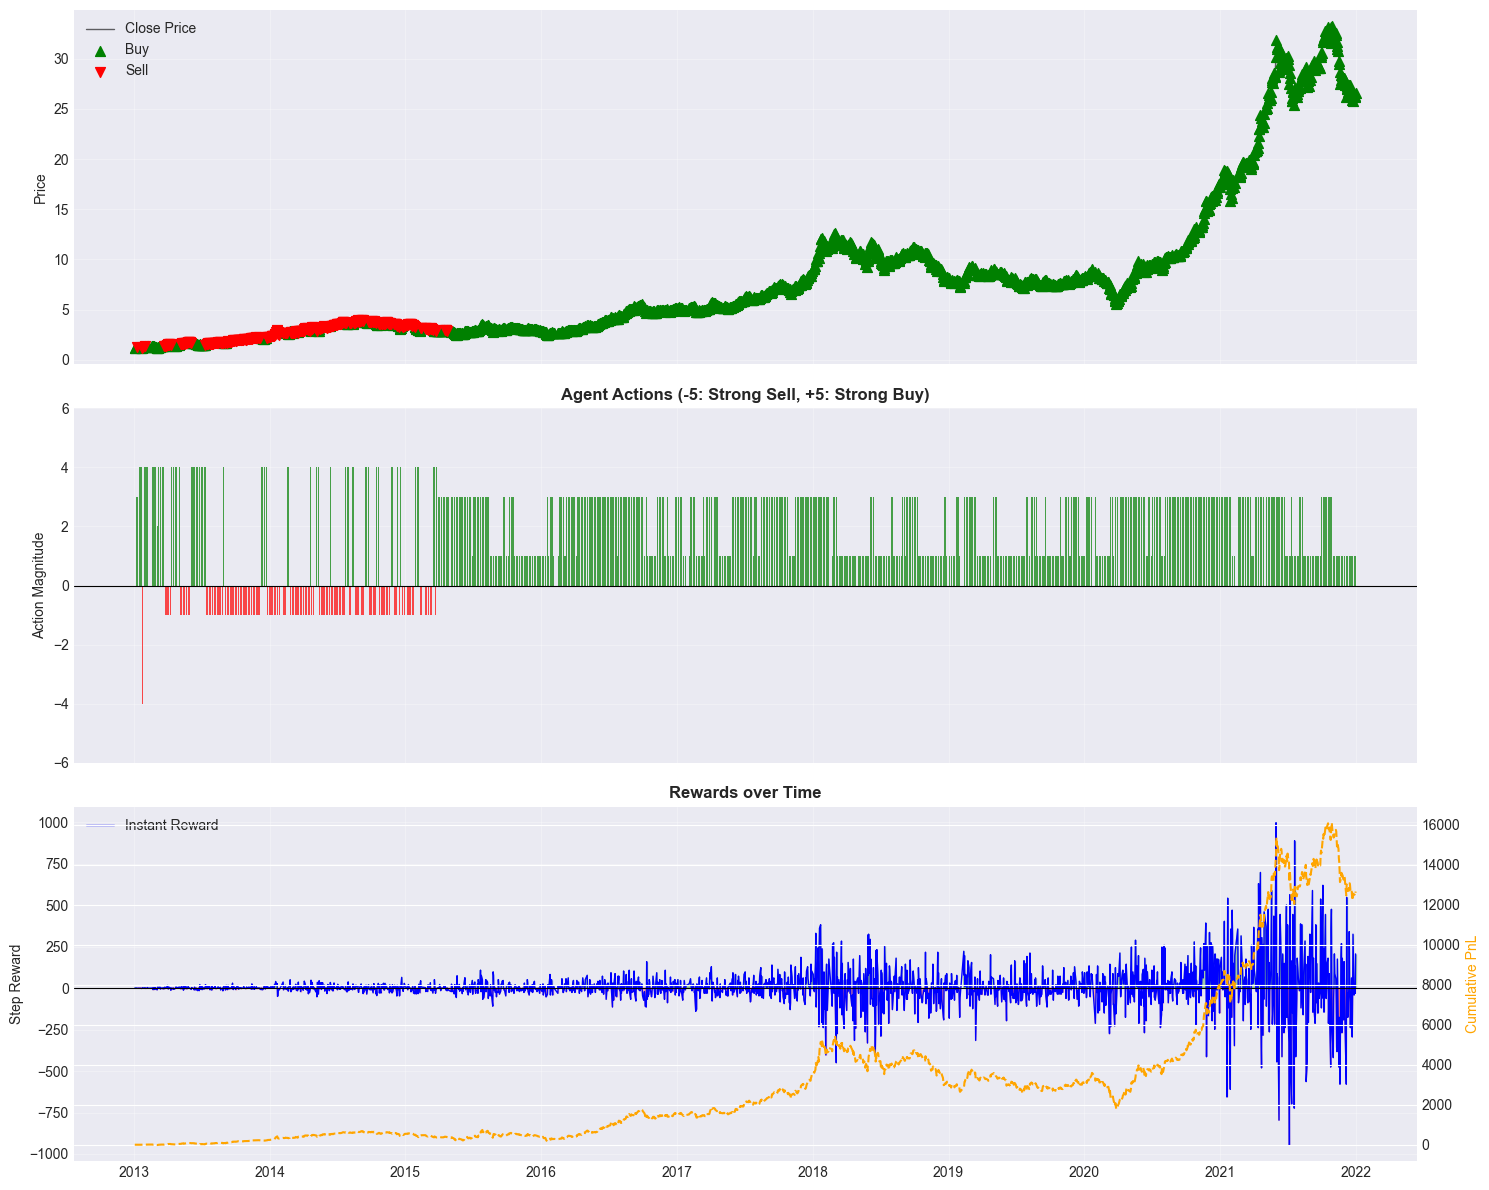

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. CHUẨN BỊ DỮ LIỆU ĐỂ VẼ
# ---------------------------------------------------------
# Lấy phần dữ liệu tương ứng với quá trình simulation (bỏ dòng đầu như lúc simulate)
plot_df = df_processed[1:].reset_index(drop=True).copy()

# Thêm Action và Reward vào DataFrame
plot_df['action'] = actions
plot_df['reward'] = rewards

# Chuyển đổi cột time sang datetime để hiển thị trục X cho đẹp
plot_df['date'] = pd.to_datetime(plot_df['time'], format='%d/%m/%Y')
plot_df.set_index('date', inplace=True)

# ---------------------------------------------------------
# 2. VẼ BIỂU ĐỒ (3 Subplots: Giá, Action, Reward)
# ---------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# --- Subplot 1: Giá cổ phiếu & Điểm Mua/Bán (Để đối chiếu) ---
axes[0].plot(plot_df.index, plot_df['close'], label='Close Price', color='black', alpha=0.6, linewidth=1)

# Lấy các điểm Mua (Action > 0) và Bán (Action < 0)
buys = plot_df[plot_df['action'] > 0]
sells = plot_df[plot_df['action'] < 0]

# Vẽ mũi tên/chấm Mua Bán
axes[0].scatter(buys.index, buys['close'], marker='^', color='green', label='Buy', s=50, zorder=5)
axes[0].scatter(sells.index, sells['close'], marker='v', color='red', label='Sell', s=50, zorder=5)

# axes[0].set_title(f'Stock Price & Trading Signals (ACB)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# --- Subplot 2: Actions (Hành động của Agent) ---
# Dùng Bar chart để thấy rõ cường độ (-5 đến 5)
colors = np.where(plot_df['action'] >= 0, 'green', 'red')
axes[1].bar(plot_df.index, plot_df['action'], color=colors, alpha=0.7, width=1.0)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_ylim(-6, 6)
axes[1].set_title('Agent Actions (-5: Strong Sell, +5: Strong Buy)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Action Magnitude')
axes[1].grid(True, alpha=0.3)

# --- Subplot 3: Rewards (Phần thưởng nhận được) ---
# Dùng Line chart + Fill area
axes[2].plot(plot_df.index, plot_df['reward'], color='blue', linewidth=1, label='Instant Reward')
axes[2].fill_between(plot_df.index, 0, plot_df['reward'], where=(plot_df['reward'] >= 0), color='green', alpha=0.3)
axes[2].fill_between(plot_df.index, 0, plot_df['reward'], where=(plot_df['reward'] < 0), color='red', alpha=0.3)

# Vẽ thêm đường Cumulative Reward (Lợi nhuận tích lũy) để dễ đánh giá
cum_reward = plot_df['reward'].cumsum()
ax2_twin = axes[2].twinx()
ax2_twin.plot(plot_df.index, cum_reward, color='orange', linestyle='--', linewidth=1.5, label='Cumulative Reward')
ax2_twin.set_ylabel('Cumulative PnL', color='orange')

axes[2].set_title('Rewards over Time', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Step Reward')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='black', linewidth=0.8)

# --- Layout ---
plt.tight_layout()
plt.show()

In [24]:
def calculate_reward_components(states, actions, prices):
    """
    Tính 4 thành phần reward ở ĐƠN VỊ THÔ (tiền tệ) theo đúng quy ước RL:
    r_t sinh ra khi đi từ (s_t, a_t) -> s_{t+1}.

    Yêu cầu sửa: đúng thứ tự trừ theo công thức, bỏ hoàn toàn phần CHIA (tính %).

    Đầu vào:
      - states: list/array các trạng thái (s_0..s_T), mỗi state: [price, balance, shares, ...]
      - actions: list/array hành động (a_0..a_{T-1})
      - prices:  list/np.array giá đóng cửa (P_0..P_T)

    Đầu ra:
      - R_profit, R_risk, R_position, R_stability: mỗi mảng độ dài T (đơn vị tiền)
    """
    # Số bước hợp lệ (tránh lệch chiều dài)
    n = min(len(states) - 1, len(actions), len(prices) - 1)

    # 1) Khởi tạo
    R_profit = np.zeros(n)
    R_risk = np.zeros(n)
    R_position = np.zeros(n)
    R_stability = np.zeros(n)

    # 2) Chỉ số phụ trợ
    MA10 = np.convolve(np.asarray(prices), np.ones(10) / 10, mode='same')  # cho R_position (không chia %)
    running_max_price = -np.inf  # cho R_risk: max(P_0..P_t)

    # 3) Vòng lặp cho từng bước t
    for t in range(n):
        P_t = float(prices[t])
        P_next = float(prices[t + 1])

        # Cập nhật đỉnh giá lịch sử (running max) dùng đúng thứ tự
        if P_t > running_max_price:
            running_max_price = P_t

        # Hành động tại t -> quy về dấu: 1 (mua), -1 (bán), 0 (giữ)
        a_t = actions[t]
        try:
            a_t_val = float(a_t)
        except Exception:
            a_t_val = a_t
        action_sign = 1 if a_t_val > 0 else (-1 if a_t_val < 0 else 0)

        # Trích xuất số cổ phiếu đang nắm giữ tại t
        h_t = float(states[t][2])

        # ---------------------------------------------------------------
        # 1) R_profit (ĐƠN VỊ THÔ): (P_{t+1} - P_t) * h_t
        #    (BỎ chia theo %; dùng đúng thứ tự P_{t+1} - P_t)
        # ---------------------------------------------------------------
        R_profit[t] = (P_next - P_t) * h_t

        # ---------------------------------------------------------------
        # 2) R_risk (ĐƠN VỊ THÔ): -| (running_max_price - P_t) | * |h_t|
        #    (BỎ chia theo %; chú ý THỨ TỰ TRỪ là peak - current)
        # ---------------------------------------------------------------
        drawdown_raw = running_max_price - P_t  # đúng thứ tự: đỉnh - hiện tại
        R_risk[t] = -abs(drawdown_raw) * abs(h_t)

        # ---------------------------------------------------------------
        # 3) R_position (ĐƠN VỊ THÔ): so sánh sign(P_t - MA10_t) với sign(a_t)
        #    Nếu cùng dấu: + (P_t * |h_t|); ngược dấu: - (P_t * |h_t|); nếu a_t=0 -> 0
        #    (BỎ chia %, chỉ dùng mức giá làm thang đo theo vị thế)
        # ---------------------------------------------------------------
        trend_val = P_t - MA10[t]
        sign_trend = 1 if trend_val > 0 else (-1 if trend_val < 0 else 0)
        scale_pos = P_t * abs(h_t)
        if action_sign == 0 or scale_pos == 0:
            R_position[t] = 0.0
        elif sign_trend == action_sign:
            R_position[t] = +scale_pos
        else:
            R_position[t] = -scale_pos

        # ---------------------------------------------------------------
        # 4) R_stability (ĐƠN VỊ THÔ): -| P_{t+1} - P_t | * |h_t|
        #    (BỎ chia %, dùng đúng thứ tự chênh lệch giá trong bước t)
        # ---------------------------------------------------------------
        R_stability[t] = -abs(P_next - P_t) * abs(h_t)

    return R_profit, R_risk, R_position, R_stability

# Tính toán 4 components theo (s_t, a_t) -> r_t (đơn vị thô)
prices = df_processed['close'].values
R_profit, R_risk, R_position, R_stability = calculate_reward_components(states, actions, prices)

# Chuyển rewards từ môi trường (nếu có)
R_original = np.array(rewards)

print("✓ Đã tính toán 4 reward components (ĐƠN VỊ THÔ, không chia %):")
print(f"  R_profit: mean={R_profit.mean():.4f}, std={R_profit.std():.4f}")
print(f"  R_risk: mean={R_risk.mean():.4f}, std={R_risk.std():.4f}")
print(f"  R_position: mean={R_position.mean():.4f}, std={R_position.std():.4f}")
print(f"  R_stability: mean={R_stability.mean():.4f}, std={R_stability.std():.4f}")
print(f"  R_original: mean={R_original.mean():.4f}, std={R_original.std():.4f}")

✓ Đã tính toán 4 reward components (ĐƠN VỊ THÔ, không chia %):
  R_profit: mean=5.6303, std=118.1491
  R_risk: mean=-782.4944, std=940.5693
  R_position: mean=186.7981, std=5573.3036
  R_stability: mean=-61.4645, std=101.0595
  R_original: mean=5.6314, std=118.1513


In [25]:
R_risk

array([   -0.  ,    -0.  ,    -0.  , ..., -3613.83, -3613.83, -3644.85])

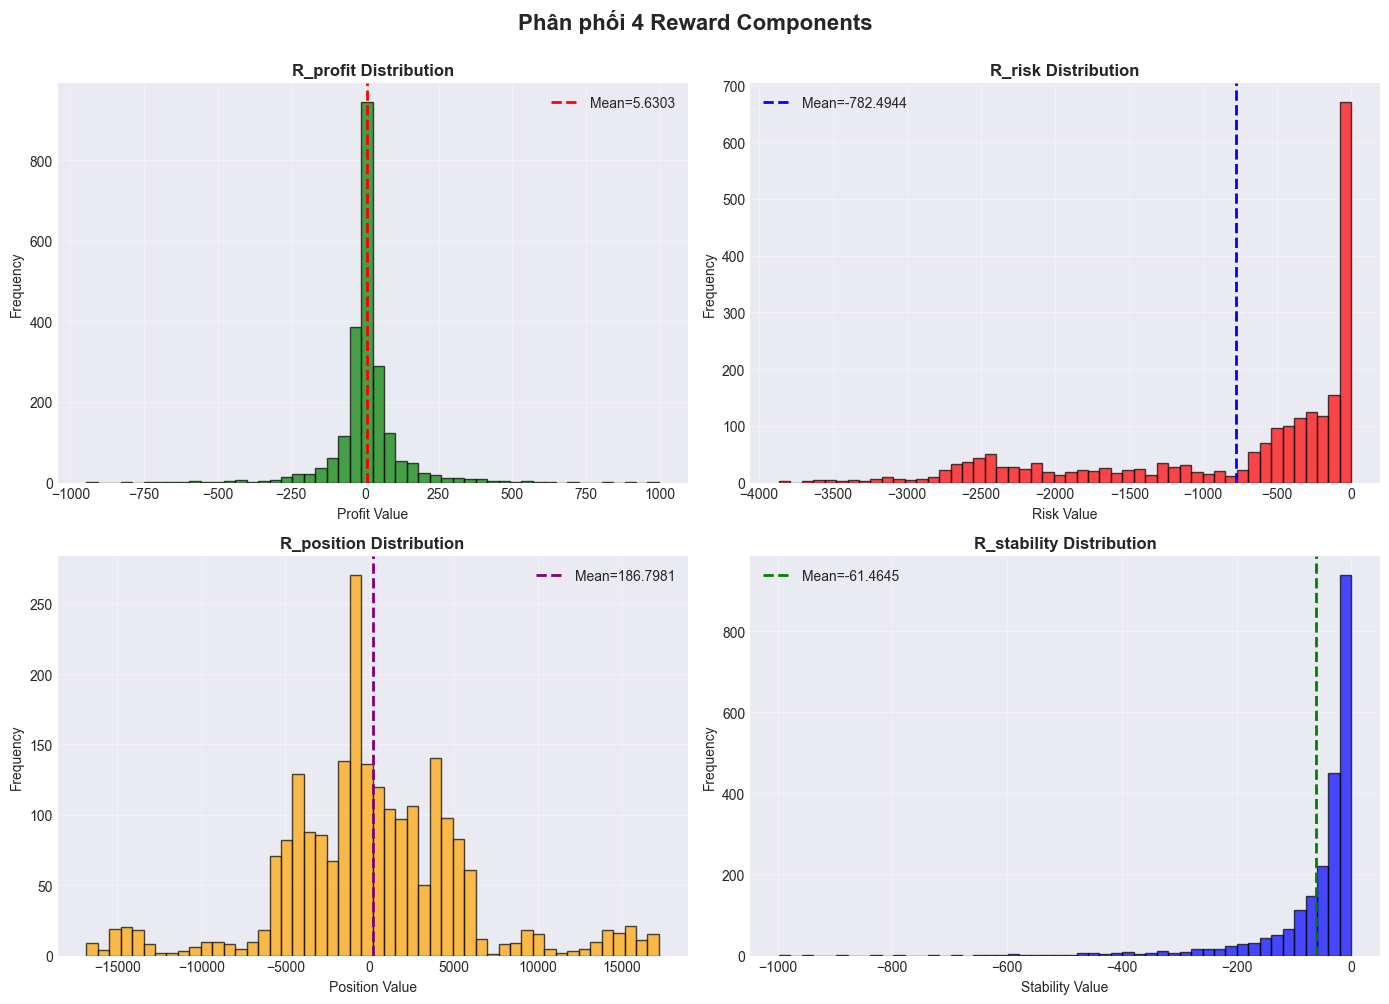

In [26]:
# Histogram phân phối của 4 components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].hist(R_profit, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_title('R_profit Distribution', fontweight='bold')
axes[0,0].set_xlabel('Profit Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(R_profit.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={R_profit.mean():.4f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(R_risk, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_title('R_risk Distribution', fontweight='bold')
axes[0,1].set_xlabel('Risk Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(R_risk.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean={R_risk.mean():.4f}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(R_position, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('R_position Distribution', fontweight='bold')
axes[1,0].set_xlabel('Position Value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(R_position.mean(), color='purple', linestyle='--', linewidth=2, label=f'Mean={R_position.mean():.4f}')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].hist(R_stability, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1,1].set_title('R_stability Distribution', fontweight='bold')
axes[1,1].set_xlabel('Stability Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(R_stability.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={R_stability.mean():.4f}')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Phân phối 4 Reward Components', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [27]:
# ============================================================================
# PHẦN 1: RDX - ĐỊNH NGHĨA WEIGHTS TỪ DOMAIN KNOWLEDGE
# ============================================================================

# Weights được định nghĩa TRƯỚC dựa trên domain knowledge trading
# KHÔNG dùng gradient hay machine learning để tính weights!

print("="*80)
print("PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION")
print("="*80)

# Domain knowledge weights cho trading strategy
w_rdx = np.array([
    0.8,  
    0.005,  
    0.005,  
    0.19   
])

print("\n✓ RDX Weights (Domain Knowledge):")
print(f"  w1 (R_profit):    {w_rdx[0]:.2f} - Profit maximization")
print(f"  w2 (R_risk):      {w_rdx[1]:.5f} - Risk management")
print(f"  w3 (R_position):  {w_rdx[2]:.5f} - Position sizing")
print(f"  w4 (R_stability): {w_rdx[3]:.5f} - Portfolio stability")
print(f"  Tổng: {w_rdx.sum():.2f}")

PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION

✓ RDX Weights (Domain Knowledge):
  w1 (R_profit):    0.80 - Profit maximization
  w2 (R_risk):      0.00500 - Risk management
  w3 (R_position):  0.00500 - Position sizing
  w4 (R_stability): 0.19000 - Portfolio stability
  Tổng: 1.00


In [28]:
# Tái tạo reward từ 4 components với RDX weights
R_components = np.column_stack([R_profit, R_risk, R_position, R_stability])
R_reconstructed = R_components @ w_rdx

# Tính metrics để validate RDX
mse = mean_squared_error(R_original, R_reconstructed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(R_original, R_reconstructed)
r2 = r2_score(R_original, R_reconstructed)
correlation = np.corrcoef(R_original, R_reconstructed)[0, 1]

print("✓ RDX Reconstruction Metrics:")
print(f"  MSE:         {mse:.6f}")
print(f"  RMSE:        {rmse:.6f}")
print(f"  MAE:         {mae:.6f}")
print(f"  R² Score:    {r2:.4f} {'✓ Good' if r2 > 0.7 else '✗ Poor'}")
print(f"  Correlation: {correlation:.4f} {'✓ Strong' if abs(correlation) > 0.8 else '~ Moderate' if abs(correlation) > 0.5 else '✗ Weak'}")

# # Phân tích reward theo action type
# print("\n✓ Reward Analysis by Action Type:")
# for action_type, condition in [('BUY', np.array(actions) > 0), 
#                                 ('SELL', np.array(actions) < 0), 
#                                 ('HOLD', np.array(actions) == 0)]:
#     if np.any(condition):
#         avg_original = R_original[condition].mean()
#         avg_reconstructed = R_reconstructed[condition].mean()
#         error = abs(avg_original - avg_reconstructed)
#         count = condition.sum()
#         print(f"  {action_type:4s}: R_orig={avg_original:7.4f}, R_recon={avg_reconstructed:7.4f}, err={error:.4f}, n={count}")

# Phân tích đóng góp từng component
print("\n✓ Average Contribution by Component:")
contrib_profit_avg = (w_rdx[0] * R_profit).mean()
contrib_risk_avg = (w_rdx[1] * R_risk).mean()
contrib_position_avg = (w_rdx[2] * R_position).mean()
contrib_stability_avg = (w_rdx[3] * R_stability).mean()

print(f"  Profit contribution:    {contrib_profit_avg:+.4f} ({contrib_profit_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Risk contribution:      {contrib_risk_avg:+.4f} ({contrib_risk_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Position contribution:  {contrib_position_avg:+.4f} ({contrib_position_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Stability contribution: {contrib_stability_avg:+.4f} ({contrib_stability_avg/R_reconstructed.mean()*100:+.1f}%)")

✓ RDX Reconstruction Metrics:
  MSE:         2618.930465
  RMSE:        51.175487
  MAE:         29.333522
  R² Score:    0.8124 ✓ Good
  Correlation: 0.9257 ✓ Strong

✓ Average Contribution by Component:
  Profit contribution:    +4.5042 (-44.4%)
  Risk contribution:      -3.9125 (+38.5%)
  Position contribution:  +0.9340 (-9.2%)
  Stability contribution: -11.6783 (+115.0%)


In [29]:
# # Weighted contributions của từng component với RDX weights
# contrib_profit = w_rdx[0] * R_profit
# contrib_risk = w_rdx[1] * R_risk
# contrib_position = w_rdx[2] * R_position
# contrib_stability = w_rdx[3] * R_stability

# # Stacked Area Chart và Timeline
# fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# # Subplot 1: Stacked area chart
# x = np.arange(len(contrib_profit))
# axes[0].fill_between(x, 0, contrib_profit, label='Profit', alpha=0.7, color='green')
# axes[0].fill_between(x, contrib_profit, contrib_profit + contrib_risk, 
#                      label='Risk', alpha=0.7, color='red')
# axes[0].fill_between(x, contrib_profit + contrib_risk, 
#                      contrib_profit + contrib_risk + contrib_position,
#                      label='Position', alpha=0.7, color='orange')
# axes[0].fill_between(x, contrib_profit + contrib_risk + contrib_position,
#                      R_reconstructed, label='Stability', alpha=0.7, color='blue')
# axes[0].plot(R_original, 'k--', linewidth=2, alpha=0.6, label='R_original')
# axes[0].set_title('RDX: Stacked Reward Components Timeline (Weighted)', fontsize=14, fontweight='bold')
# axes[0].set_xlabel('Time Step')
# axes[0].set_ylabel('Reward Contribution')
# axes[0].legend(loc='best')
# axes[0].grid(True, alpha=0.3)

# # Subplot 2: Individual components over time
# axes[1].plot(R_profit, label='R_profit (raw)', alpha=0.7, linewidth=1.5, color='green')
# axes[1].plot(R_risk, label='R_risk (raw)', alpha=0.7, linewidth=1.5, color='red')
# axes[1].plot(R_position, label='R_position (raw)', alpha=0.7, linewidth=1.5, color='orange')
# axes[1].plot(R_stability, label='R_stability (raw)', alpha=0.7, linewidth=1.5, color='blue')
# axes[1].set_title('RDX: Raw Reward Components Over Time', fontsize=14, fontweight='bold')
# axes[1].set_xlabel('Time Step')
# axes[1].set_ylabel('Reward Value (unweighted)')
# axes[1].legend(loc='best')
# axes[1].grid(True, alpha=0.3)

# # Subplot 3: Weighted contributions
# axes[2].plot(contrib_profit, label=f'Profit (w={w_rdx[0]:.1f})', linewidth=2, alpha=0.8, color='green')
# axes[2].plot(contrib_risk, label=f'Risk (w={w_rdx[1]:.1f})', linewidth=2, alpha=0.8, color='red')
# axes[2].plot(contrib_position, label=f'Position (w={w_rdx[2]:.1f})', linewidth=2, alpha=0.8, color='orange')
# axes[2].plot(contrib_stability, label=f'Stability (w={w_rdx[3]:.1f})', linewidth=2, alpha=0.8, color='blue')
# axes[2].set_title('RDX: Weighted Contributions Over Time', fontsize=14, fontweight='bold')
# axes[2].set_xlabel('Time Step')
# axes[2].set_ylabel('Weighted Contribution')
# axes[2].legend(loc='best')
# axes[2].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # # Box plot - Phân phối
# # fig, ax = plt.subplots(figsize=(12, 7))
# # data_to_plot = [R_profit, R_risk, R_position, R_stability]
# # bp = ax.boxplot(data_to_plot, labels=['R_profit', 'R_risk', 'R_position', 'R_stability'],
# #                 patch_artist=True, showmeans=True)

# # colors = ['green', 'red', 'orange', 'blue']
# # for patch, color in zip(bp['boxes'], colors):
# #     patch.set_facecolor(color)
# #     patch.set_alpha(0.6)

# # ax.set_title('RDX: Box Plot - Phân phối 4 Reward Components', fontsize=16, fontweight='bold')
# # ax.set_ylabel('Reward Value')
# # ax.grid(True, axis='y', alpha=0.3)
# # plt.tight_layout()
# # plt.show()

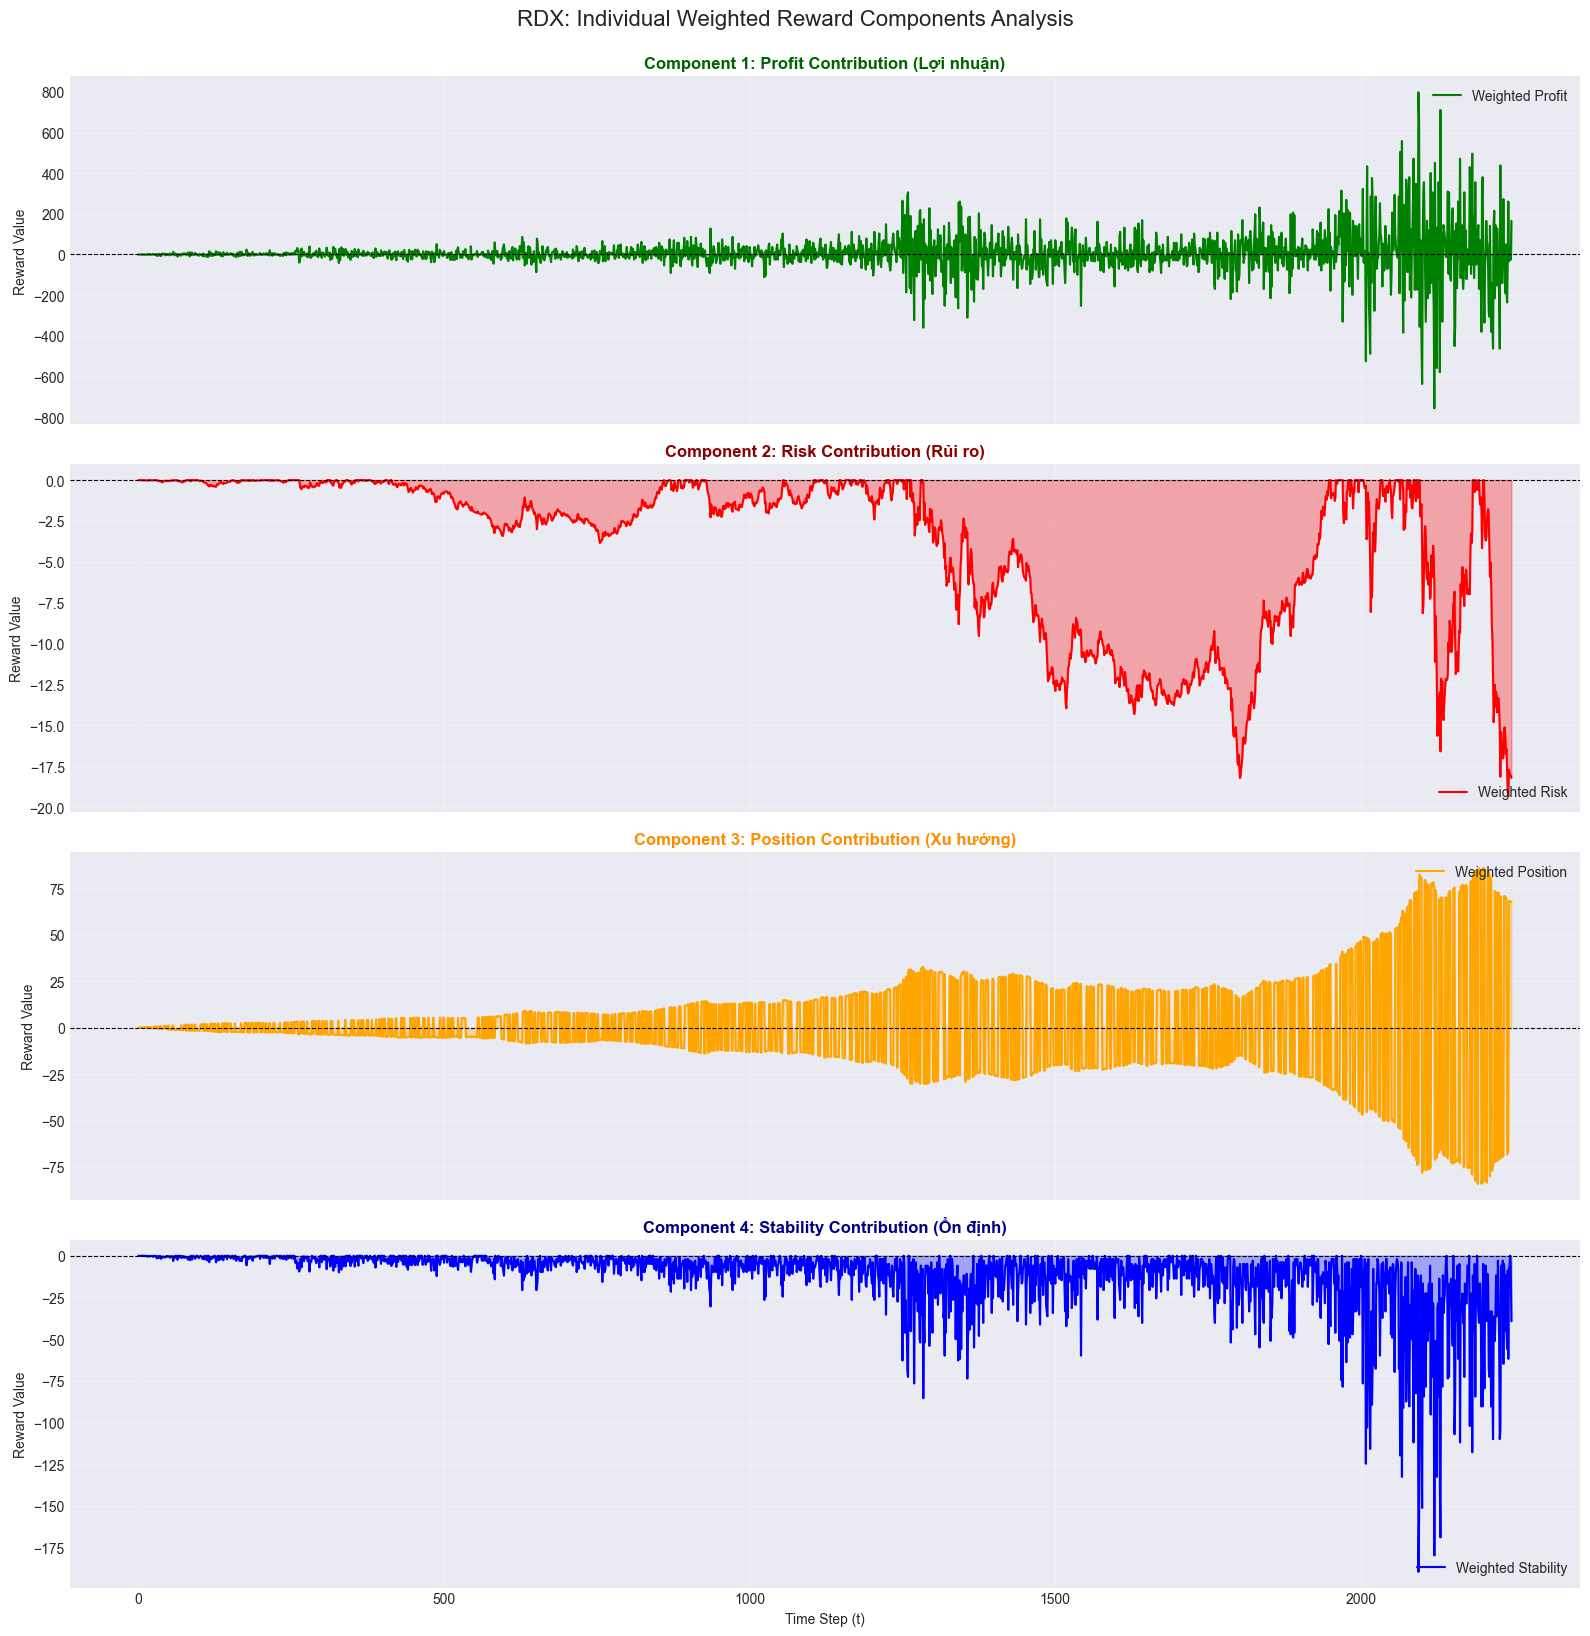

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử các biến contrib_* đã được tính toán như code của bạn:
# contrib_profit = w_rdx[0] * R_profit
# ...

# Weighted contributions của từng component với RDX weights
contrib_profit = w_rdx[0] * R_profit
contrib_risk = w_rdx[1] * R_risk
contrib_position = w_rdx[2] * R_position
contrib_stability = w_rdx[3] * R_stability

# Thiết lập figure với 4 dòng (mỗi dòng 1 component)
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
x = np.arange(len(contrib_profit))

# --- 1. PROFIT CONTRIBUTION ---
color_1 = 'green'
axes[0].plot(x, contrib_profit, color=color_1, label='Weighted Profit', linewidth=1.5)
axes[0].fill_between(x, 0, contrib_profit, color=color_1, alpha=0.3)
axes[0].set_title('Component 1: Profit Contribution (Lợi nhuận)', fontsize=12, fontweight='bold', color='darkgreen')
axes[0].set_ylabel('Reward Value')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')

# --- 2. RISK CONTRIBUTION ---
color_2 = 'red'
axes[1].plot(x, contrib_risk, color=color_2, label='Weighted Risk', linewidth=1.5)
axes[1].fill_between(x, 0, contrib_risk, color=color_2, alpha=0.3)
axes[1].set_title('Component 2: Risk Contribution (Rủi ro)', fontsize=12, fontweight='bold', color='darkred')
axes[1].set_ylabel('Reward Value')
axes[1].legend(loc='lower right') # Risk thường âm nên để legend ở dưới cho dễ nhìn
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')

# --- 3. POSITION CONTRIBUTION ---
color_3 = 'orange'
axes[2].plot(x, contrib_position, color=color_3, label='Weighted Position', linewidth=1.5)
axes[2].fill_between(x, 0, contrib_position, color=color_3, alpha=0.3)
axes[2].set_title('Component 3: Position Contribution (Xu hướng)', fontsize=12, fontweight='bold', color='darkorange')
axes[2].set_ylabel('Reward Value')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='black', linewidth=0.8, linestyle='--')

# --- 4. STABILITY CONTRIBUTION ---
color_4 = 'blue'
axes[3].plot(x, contrib_stability, color=color_4, label='Weighted Stability', linewidth=1.5)
axes[3].fill_between(x, 0, contrib_stability, color=color_4, alpha=0.3)
axes[3].set_title('Component 4: Stability Contribution (Ổn định)', fontsize=12, fontweight='bold', color='darkblue')
axes[3].set_ylabel('Reward Value')
axes[3].set_xlabel('Time Step (t)')
axes[3].legend(loc='lower right')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(0, color='black', linewidth=0.8, linestyle='--')

# Tinh chỉnh layout
plt.tight_layout()
plt.suptitle('RDX: Individual Weighted Reward Components Analysis', y=1.02, fontsize=16)
plt.show()

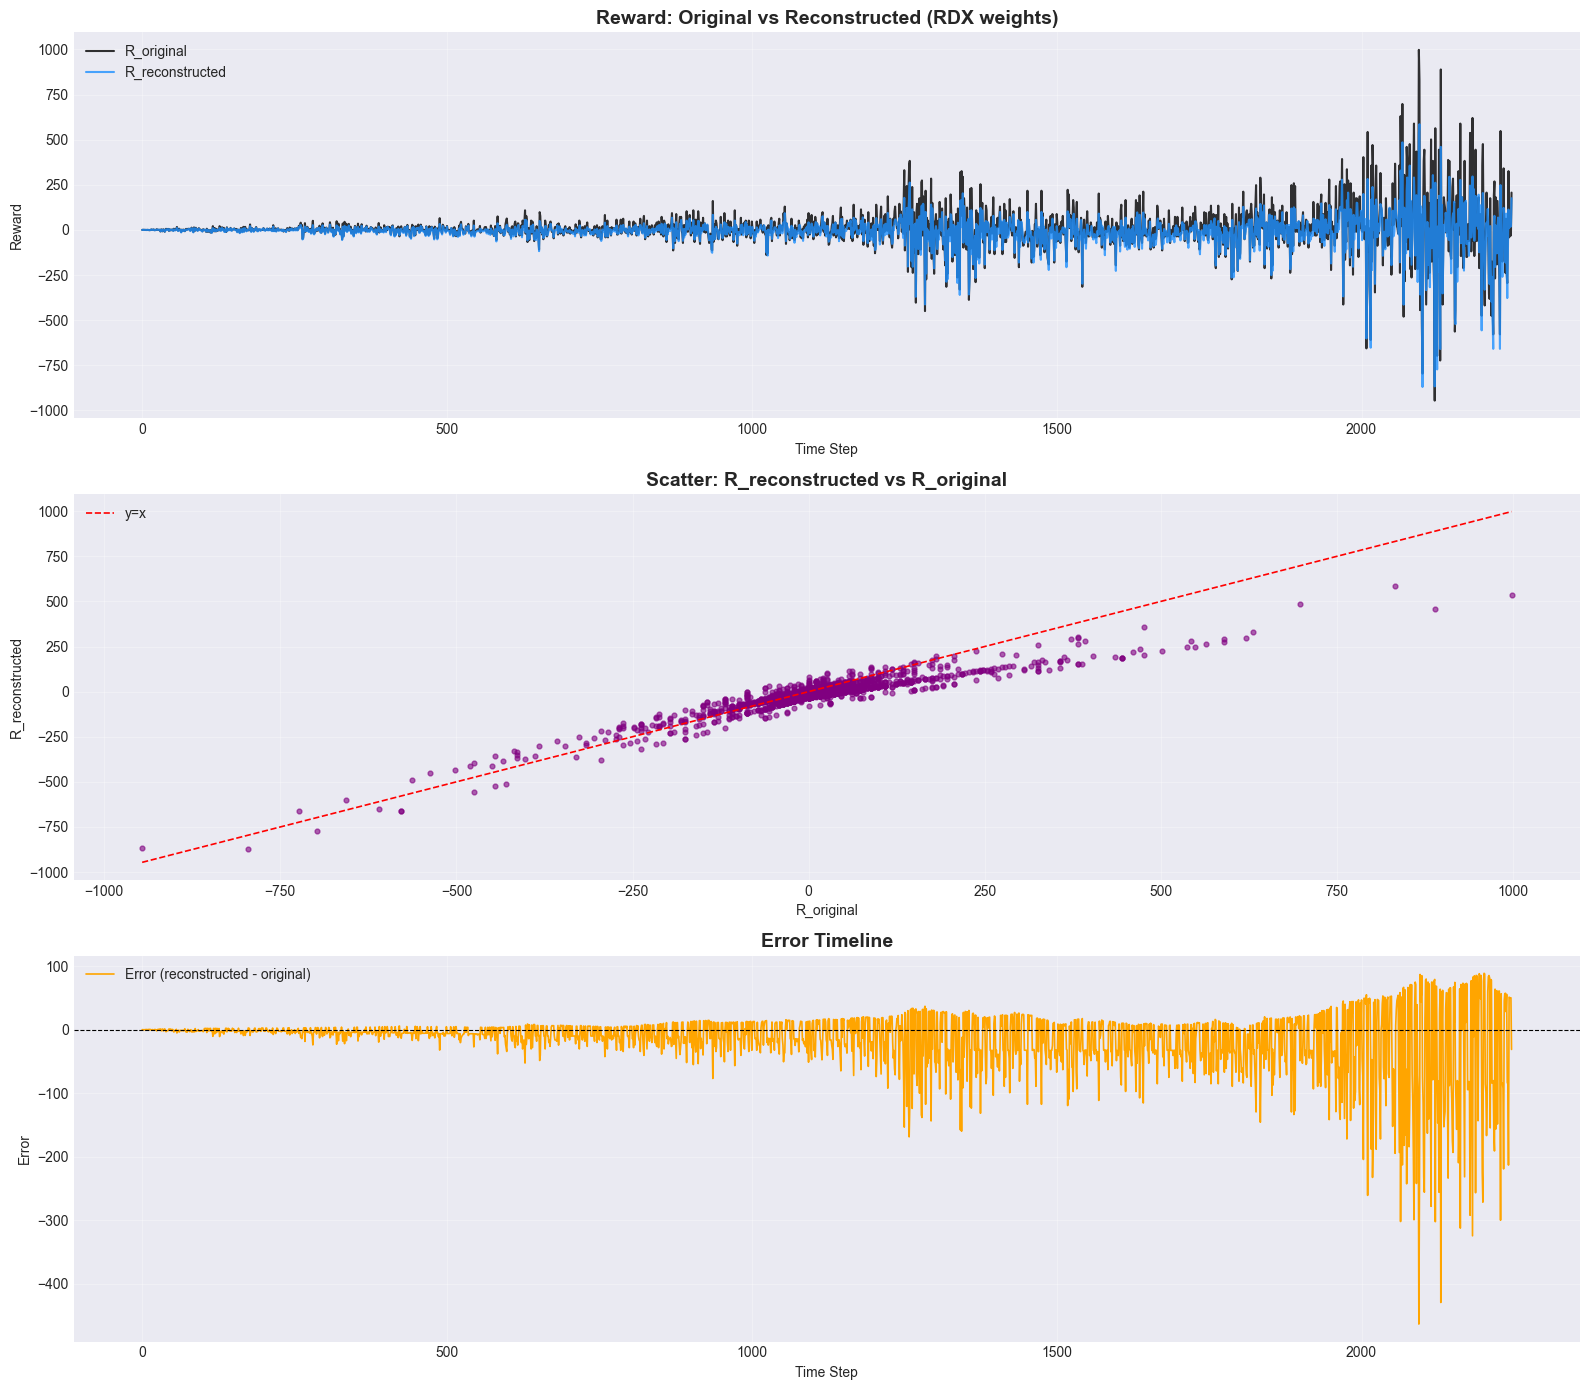

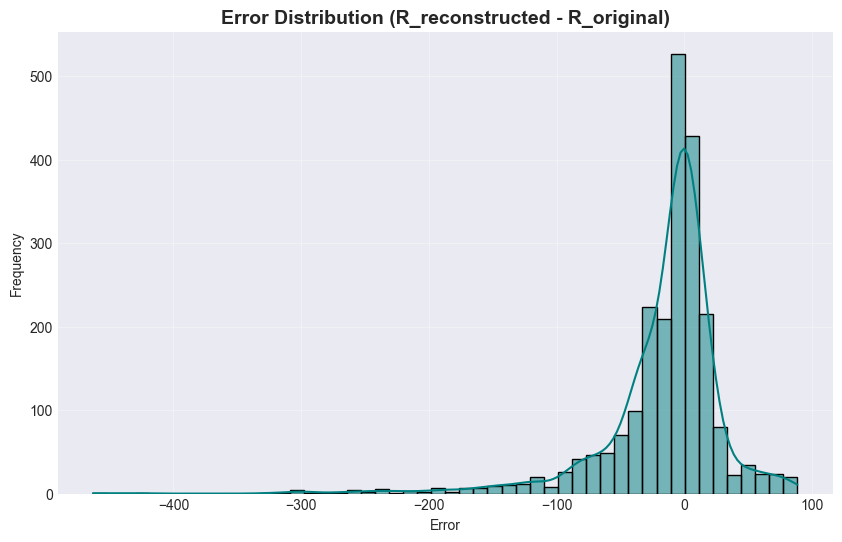

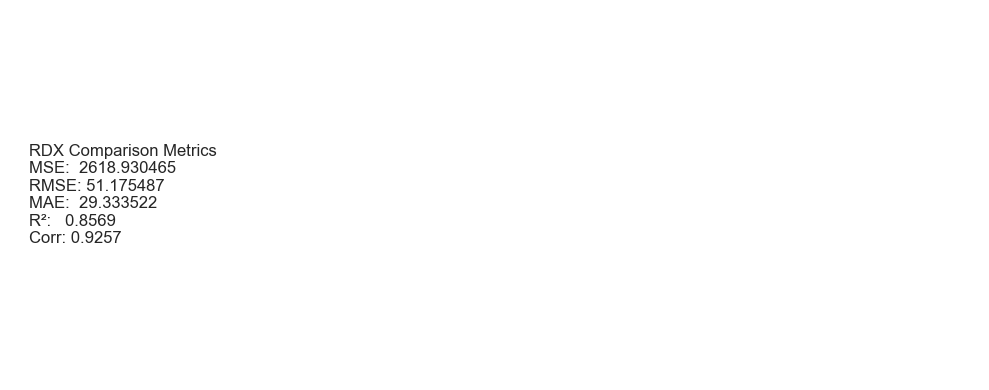

In [31]:
# So sánh trực quan R_reconstructed (từ weights) với R_original (reward gốc)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Giả định các biến đã có: R_original, R_reconstructed, w_rdx, R_profit, R_risk, R_position, R_stability

# 1) Line plot: Original vs Reconstructed theo thời gian
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

x = np.arange(len(R_reconstructed))
axes[0].plot(x, R_original, label='R_original', color='black', linewidth=1.5, alpha=0.8)
axes[0].plot(x, R_reconstructed, label='R_reconstructed', color='dodgerblue', linewidth=1.5, alpha=0.8)
axes[0].set_title('Reward: Original vs Reconstructed (RDX weights)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Reward')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# 2) Scatter: Original vs Reconstructed + đường y=x
axes[1].scatter(R_original, R_reconstructed, s=12, alpha=0.6, color='purple')
min_val = min(R_original.min(), R_reconstructed.min())
max_val = max(R_original.max(), R_reconstructed.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.2, label='y=x')
axes[1].set_title('Scatter: R_reconstructed vs R_original', fontsize=14, fontweight='bold')
axes[1].set_xlabel('R_original')
axes[1].set_ylabel('R_reconstructed')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# 3) Sai số: e = R_reconstructed - R_original (timeline + histogram)
error = R_reconstructed - R_original
axes[2].plot(x, error, color='orange', linewidth=1.2, label='Error (reconstructed - original)')
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[2].set_title('Error Timeline', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Error')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Histogram sai số + KDE
plt.figure(figsize=(10,6))
sns.histplot(error, bins=50, kde=True, color='teal')
plt.title('Error Distribution (R_reconstructed - R_original)', fontsize=14, fontweight='bold')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 5) Bảng metrics hiển thị trực quan trên hình
mse = ((error)**2).mean()
rmse = np.sqrt(mse)
mae = np.abs(error).mean()
r2 = np.corrcoef(R_original, R_reconstructed)[0,1]**2
corr = np.corrcoef(R_original, R_reconstructed)[0,1]

fig, ax = plt.subplots(figsize=(10,4))
ax.axis('off')
text = (
    f"RDX Comparison Metrics\n"
    f"MSE:  {mse:.6f}\n"
    f"RMSE: {rmse:.6f}\n"
    f"MAE:  {mae:.6f}\n"
    f"R²:   {r2:.4f}\n"
    f"Corr: {corr:.4f}"
)
ax.text(0.02, 0.5, text, fontsize=12, va='center', ha='left')
plt.tight_layout()
plt.show()

# # 6) Optional: Stacked contributions vs Original (đã vẽ trước, nhưng gom lại ở đây nếu cần)
# # Đây là biểu đồ thể hiện tổng đóng góp từng component (weighted) so với reward gốc
# contrib_profit = w_rdx[0] * R_profit
# contrib_risk = w_rdx[1] * R_risk
# contrib_position = w_rdx[2] * R_position
# contrib_stability = w_rdx[3] * R_stability

# fig, ax = plt.subplots(figsize=(16, 6))
# ax.plot(R_original, 'k--', linewidth=1.5, alpha=0.7, label='R_original')
# ax.plot(R_reconstructed, color='blue', linewidth=1.8, alpha=0.8, label='R_reconstructed')
# ax.plot(contrib_profit, color='green', alpha=0.6, label='Profit (weighted)')
# ax.plot(contrib_risk, color='red', alpha=0.6, label='Risk (weighted)')
# ax.plot(contrib_position, color='orange', alpha=0.6, label='Position (weighted)')
# ax.plot(contrib_stability, color='blue', alpha=0.4, linestyle=':', label='Stability (weighted)')
# ax.set_title('Original vs Reconstructed and Component Contributions', fontsize=14, fontweight='bold')
# ax.set_xlabel('Time Step')
# ax.set_ylabel('Reward / Contribution')
# ax.legend(loc='best')
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [32]:
# Lưu tất cả biểu đồ RDX vào 1 PDF theo tên chuẩn
# RDX_Report_<agentStage>_SARSA_<dataStage>_<ticker>.pdf
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
import re

# 1) Suy ra tên mô hình, agentStage và ticker từ model_path
agent_name = None
agent_stage = 'unknown'
if 'model_path' in globals() and isinstance(model_path, str):
    agent_name = os.path.splitext(os.path.basename(model_path))[0]  # ví dụ: sarsa_good_acb
    m_agent = re.search(r'sarsa_(good|bad)', agent_name, re.IGNORECASE)
    if m_agent:
        agent_stage = m_agent.group(1).lower()
else:
    agent_name = 'SARSA_model'

# ticker lấy từ dữ liệu 
if 'df_processed' in globals():
    # thử lấy từ tên file nguồn nếu có path; fallback dùng cột 'symbol' 
    src_hint = 'good_test_GAS'
    m = re.search(r'([A-Z]{3,5})', src_hint)
    ticker = m.group(1) if m else 'GAS'
else:
    ticker = 'GAS'

# 2) Suy ra dataStage (good/bad) từ tên file dữ liệu đã truyền vào
data_stage = 'unknown'
try:
    src_paths = []
    if 'df_processed_train' in globals():
        src_paths.append('good_train_GAS')  # thay bằng nguồn thực tế nếu có
    if 'df_processed_test' in globals():
        src_paths.append('good_test_GAS')   # thay bằng nguồn thực tế nếu có
    joined = ' '.join(src_paths).lower()
    if 'good' in joined:
        data_stage = 'good'
    elif 'bad' in joined:
        data_stage = 'bad'
except Exception:
    pass

# 3) Thiết lập tên file và thư mục
output_dir = Path('d:/NCKH/SARSA_FinancialRL/application/results/xai_analysis/')
output_dir.mkdir(parents=True, exist_ok=True)
pdf_path = output_dir / f"RDX_Report_{agent_stage}_SARSA_{data_stage}_{ticker}.pdf"
print(f"✓ Đang lưu báo cáo RDX vào: {pdf_path}")

# 4) Tạo lại các biểu đồ chính và lưu vào PDF (khổ A4)
a4_w, a4_h = 8.27, 11.69
pdf = PdfPages(str(pdf_path))

# Chuẩn bị dữ liệu/biến cần thiết
assert 'R_original' in globals() and 'R_reconstructed' in globals(), 'Cần tính R_original và R_reconstructed trước.'
assert 'R_profit' in globals() and 'R_risk' in globals() and 'R_position' in globals() and 'R_stability' in globals(), 'Thiếu RDX components.'

# -------- Plot 0: Close price timeline (data used in simulation) --------
fig0, ax0 = plt.subplots(1, 1, figsize=(a4_w, a4_h*0.7))
if 'df_processed' in globals():
    price_df = df_processed[1:].reset_index(drop=True).copy()
    if 'time' in price_df.columns:
        idx = pd.to_datetime(price_df['time'], format='%d/%m/%Y')
    else:
        idx = np.arange(len(price_df))
    ax0.plot(idx, price_df['close'], color='black', linewidth=1.2, alpha=0.8, label='Close')
    ax0.set_title(f'Close Price Timeline ({ticker})')
    ax0.set_xlabel('Date' if 'time' in price_df.columns else 'Time Step')
    ax0.set_ylabel('Price')
    ax0.legend(loc='best')
    ax0.grid(True, alpha=0.3)
else:
    ax0.text(0.5, 0.5, 'df_processed not available', ha='center', va='center')
plt.tight_layout()
pdf.savefig(fig0); plt.close(fig0)

# -------- Plot 1: Timeline Original vs Reconstructed --------
fig1, ax1 = plt.subplots(1, 1, figsize=(a4_w, a4_h*0.7))
x = np.arange(len(R_reconstructed))
ax1.plot(x, R_original, label='R_original', color='black', linewidth=1.5, alpha=0.8)
ax1.plot(x, R_reconstructed, label='R_reconstructed', color='dodgerblue', linewidth=1.5, alpha=0.8)
ax1.set_title(f'Reward Timeline: Original vs Reconstructed ({agent_name})')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Reward')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
pdf.savefig(fig1); plt.close(fig1)

# -------- Plot 2: Scatter Original vs Reconstructed --------
fig2, ax2 = plt.subplots(1, 1, figsize=(a4_w, a4_h*0.7))
ax2.scatter(R_original, R_reconstructed, s=10, alpha=0.6, color='purple')
min_val = min(R_original.min(), R_reconstructed.min())
max_val = max(R_original.max(), R_reconstructed.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.2, label='y=x')
ax2.set_title('Scatter: R_reconstructed vs R_original')
ax2.set_xlabel('R_original')
ax2.set_ylabel('R_reconstructed')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
pdf.savefig(fig2); plt.close(fig2)

# -------- Plot 3: Error timeline --------
error = R_reconstructed - R_original
fig3, ax3 = plt.subplots(1, 1, figsize=(a4_w, a4_h*0.7))
ax3.plot(x, error, color='orange', linewidth=1.2, label='Error (reconstructed - original)')
ax3.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax3.set_title('Error Timeline')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Error')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
plt.tight_layout()
pdf.savefig(fig3); plt.close(fig3)

# -------- Plot 4: Error distribution --------
fig4, ax4 = plt.subplots(1, 1, figsize=(a4_w, a4_h*0.7))
sns.histplot(error, bins=50, kde=True, color='teal', ax=ax4)
ax4.set_title('Error Distribution (R_reconstructed - R_original)')
ax4.set_xlabel('Error')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)
plt.tight_layout()
pdf.savefig(fig4); plt.close(fig4)

# -------- Plot 5: Components distributions (2x2) --------
fig5, axes5 = plt.subplots(2, 2, figsize=(a4_w, a4_h))
axes5[0,0].hist(R_profit, bins=50, alpha=0.7, color='green', edgecolor='black'); axes5[0,0].set_title('R_profit')
axes5[0,1].hist(R_risk, bins=50, alpha=0.7, color='red', edgecolor='black'); axes5[0,1].set_title('R_risk')
axes5[1,0].hist(R_position, bins=50, alpha=0.7, color='orange', edgecolor='black'); axes5[1,0].set_title('R_position')
axes5[1,1].hist(R_stability, bins=50, alpha=0.7, color='blue', edgecolor='black'); axes5[1,1].set_title('R_stability')
for ax in axes5.flat:
    ax.grid(True, alpha=0.3)
plt.tight_layout()
pdf.savefig(fig5); plt.close(fig5)

# -------- Plot 6: Weighted contributions (4 rows) --------
contrib_profit = w_rdx[0] * R_profit
contrib_risk = w_rdx[1] * R_risk
contrib_position = w_rdx[2] * R_position
contrib_stability = w_rdx[3] * R_stability
fig6, axes6 = plt.subplots(4, 1, figsize=(a4_w, a4_h), sharex=True)
axes6[0].plot(contrib_profit, color='green'); axes6[0].set_title('Profit (weighted)')
axes6[1].plot(contrib_risk, color='red'); axes6[1].set_title('Risk (weighted)')
axes6[2].plot(contrib_position, color='orange'); axes6[2].set_title('Position (weighted)')
axes6[3].plot(contrib_stability, color='blue'); axes6[3].set_title('Stability (weighted)')
for ax in axes6:
    ax.grid(True, alpha=0.3)
plt.tight_layout()
pdf.savefig(fig6); plt.close(fig6)

# -------- Plot 7: Metrics board --------
mse = (error**2).mean(); rmse = np.sqrt(mse); mae = np.abs(error).mean()
r2 = np.corrcoef(R_original, R_reconstructed)[0,1]**2
corr = np.corrcoef(R_original, R_reconstructed)[0,1]
fig7, ax7 = plt.subplots(figsize=(a4_w, a4_h*0.4))
ax7.axis('off')
text = (
    f"RDX Report ({agent_name})\n" +
    f"Agent: {agent_stage} | Data: {data_stage} | Ticker: {ticker}\n" +
    f"MSE:  {mse:.6f}\nRMSE: {rmse:.6f}\nMAE:  {mae:.6f}\nR²:   {r2:.4f}\nCorr: {corr:.4f}"
)
ax7.text(0.02, 0.6, text, fontsize=10, va='center', ha='left')
plt.tight_layout()
pdf.savefig(fig7); plt.close(fig7)

pdf.close()
print('✓ Đã lưu RDX report PDF hoàn tất.')

✓ Đang lưu báo cáo RDX vào: d:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\RDX_Report_good_SARSA_good_GAS.pdf
✓ Đã lưu RDX report PDF hoàn tất.


In [33]:
# Xuất PNG ghép 2 biểu đồ đứng cạnh nhau với tên theo format SHAP_Report
import os, re
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Thư mục output ---
output_dir = "D:\\NCKH\\SARSA_FinancialRL\\application\\results\\xai_analysis\\"
os.makedirs(output_dir, exist_ok=True)

# --- 2. Hàm parse tên theo format: SHAP_Report_<agentStage>_SARSA_<dataStage>_<ticker>.png ---
def build_output_png_path(model_path_var=None, df_processed=None, fallback_train_path=None, fallback_test_path=None):
    file_name_raw = os.path.splitext(os.path.basename(model_path_var))[0] if model_path_var else "sarsa_unknown_unknown"
    parts = file_name_raw.split('_')
    agentStage = (parts[1] if len(parts) > 1 else 'unknown').upper()

    dataStage = 'UNKNOWN'
    ticker = 'UNKNOWN'
    for p in [fallback_train_path, fallback_test_path]:
        if p:
            base = os.path.basename(p).lower()
            if 'good' in base:
                dataStage = 'GOOD'
            elif 'bad' in base:
                dataStage = 'BAD'
            m = re.search(r"_([A-Za-z]{2,5})\.csv$", base)
            if m:
                ticker = m.group(1).upper()
    if ticker == 'UNKNOWN' and df_processed is not None:
        try:
            if 'symbol' in df_processed.columns:
                ticker = str(df_processed['symbol'].iloc[0]).upper()
        except Exception:
            pass
    pdf_style_name = f"RDX_Report_{agentStage}_SARSA_{dataStage}_{ticker}.png"
    return os.path.join(output_dir, pdf_style_name)

# --- 3. Hàm vẽ 2 biểu đồ và lưu PNG ---
def save_two_rdx_plots_png(R_original, R_reconstructed, df_processed, model_path_var=None,
                           train_path='D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\train\\good_train_GAS.csv',
                           test_path='D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_GAS.csv'):
    """
    Tạo một ảnh PNG gồm 2 biểu đồ đứng cạnh nhau:
    - Trái: Timeline so sánh Reward gốc vs Reward tái cấu trúc (R_original vs R_reconstructed)
    - Phải: Scatter R_reconstructed vs R_original với đường y=x

    File sẽ được lưu tại output_dir với tên theo format SHAP_Report_<agentStage>_SARSA_<dataStage>_<ticker>.png
    """
    # Chuẩn bị tên file
    out_path = build_output_png_path(model_path_var=model_path_var,
                                     df_processed=df_processed,
                                     fallback_train_path=train_path,
                                     fallback_test_path=test_path)

    # Chuẩn bị dữ liệu thời gian và căn chỉnh độ dài
    try:
        dates = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
    except Exception:
        dates = np.arange(max(len(R_original), len(R_reconstructed)))

    # Căn chỉnh độ dài cho x/y để tránh lỗi shape
    T = min(len(dates), len(R_original), len(R_reconstructed))
    dates_plot = dates.iloc[:T] if hasattr(dates, 'iloc') else dates[:T]
    R_org_plot = np.asarray(R_original)[:T]
    R_rec_plot = np.asarray(R_reconstructed)[:T]

    # Tạo figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Biểu đồ trái: timeline
    ax_left = axes[0]
    ax_left.plot(dates_plot, R_org_plot, label='Original Reward', color='#1f77b4')
    ax_left.plot(dates_plot, R_rec_plot, label='Reconstructed Reward', color='#ff7f0e', alpha=0.8)
    ax_left.set_title('Reward Timeline')
    ax_left.set_xlabel('Time')
    ax_left.set_ylabel('Reward')
    ax_left.legend()

    # Biểu đồ phải: scatter với y=x
    ax_right = axes[1]
    ax_right.scatter(R_org_plot, R_rec_plot, s=10, alpha=0.7, color='#2ca02c')
    min_v = float(min(np.min(R_org_plot), np.min(R_rec_plot)))
    max_v = float(max(np.max(R_org_plot), np.max(R_rec_plot)))
    ax_right.plot([min_v, max_v], [min_v, max_v], color='black', linewidth=1, linestyle='--', label='y = x')
    ax_right.set_title('Reconstructed vs Original')
    ax_right.set_xlabel('Original Reward')
    ax_right.set_ylabel('Reconstructed Reward')
    ax_right.legend()

    plt.tight_layout()

    try:
        fig.savefig(out_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        print(f"✓ Đã lưu PNG: {out_path}")
    except PermissionError:
        print("❌ LỖI: File đang mở, vui lòng đóng ảnh PNG lại!")

# --- 4. Ví dụ gọi hàm (chạy sau khi có R_original, R_reconstructed, df_processed, và model_path/model_path_1) ---
try:
    model_path_var = model_path
except NameError:
    try:
        model_path_var = model_path_1
    except NameError:
        model_path_var = None

# Gọi hàm nếu các biến cần thiết đã tồn tại
try:
    _ = (R_original, R_reconstructed, df_processed)
    save_two_rdx_plots_png(R_original, R_reconstructed, df_processed, model_path_var=model_path_var)
except NameError:
    print("⚠ Thiếu biến R_original/R_reconstructed/df_processed. Hãy chạy các cell RDX trước.")


✓ Đã lưu PNG: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\RDX_Report_GOOD_SARSA_GOOD_GAS.png
